In [1]:
import keras
import tensorflow as tf
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import numpy as np
import IDTreeS_dataset
from classification_models.keras import Classifiers
import random
import sklearn

2023-09-04 04:51:26.302127: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-04 04:51:26.439249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set Parameters for run:

In [2]:
# Data Parameters
train_test_split_size = 0.2
random_state = 0
shuffle = True
augment_data = True

# Architecture Parameters
base_model_name ='ResNet18' #Options: ResNet18, ResNet50V2
activation = 'softmax'

# Compile options
learning_rate = 0.01
metrics = ['accuracy']
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

# Training Parameters
batch_size = 32
epochs = 20 

### Set Keras backend for image data format

In [3]:
keras.backend.set_image_data_format('channels_first')

### Load ResNet50V2 model from Keras and freeze weights

In [4]:
if base_model_name == 'ResNet50V2':
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None
    )
elif base_model_name == 'ResNet18':
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=(3,100,100), weights='imagenet', include_top=False)
else:
    raise ValueError('Base model not defined')

In [5]:
base_model.trainable = False

In [6]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 3, 100, 100)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 3, 106, 106)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 50, 50)   9408        ['zero_padding2d[0][0]']     

                                                                                                  
 stage1_unit1_sc (Conv2D)       (None, 64, 25, 25)   4096        ['stage1_unit1_relu1[0][0]']     
                                                                                                  
 add (Add)                      (None, 64, 25, 25)   0           ['stage1_unit1_conv2[0][0]',     
                                                                  'stage1_unit1_sc[0][0]']        
                                                                                                  
 stage1_unit2_bn1 (BatchNormali  (None, 64, 25, 25)  256         ['add[0][0]']                    
 zation)                                                                                          
                                                                                                  
 stage1_unit2_relu1 (Activation  (None, 64, 25, 25)  0           ['stage1_unit2_bn1[0][0]']       
 )        

### Load data and set model parameters

In [7]:
import glob

from rioxarray.exceptions import NoDataInBounds
from sklearn.preprocessing import LabelEncoder 

In [8]:
# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('./train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('./train/ITC/train_*.shp')
classes_path = './train/Field/train_data.csv'

In [9]:
# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('./train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('./train/ITC/train_*.shp')
classes_path = './train/Field/train_data.csv'

# Convert generator dataset in to suitable input for keras
ds = IDTreeS_dataset.IDTreeSDataset(rgb_paths, bboxes_paths, classes_path, augment_data=False)

ids, Y, X = ds.get_cutouts()

nclasses = len(np.unique(Y)) #Number of classes in training data

In [10]:
# Split train and test data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=train_test_split_size, random_state=random_state, shuffle=shuffle, stratify=Y)

In [11]:
ids, y_train, X_train = IDTreeS_dataset._augment_data(np.random.randint(10, size = (y_train.shape)), y_train, X_train)

In [12]:
def preprocess_data(X, Y, nclasses):
    if base_model_name == 'ResNet50V2':
        X_p = keras.applications.resnet_v2.preprocess_input(X)
    elif base_model_name == 'ResNet18':
        X_p = preprocess_input(X)
    else:
        raise ValueError('Model not defined')
    Y_p = keras.utils.to_categorical(Y, nclasses)
    return X_p, Y_p

X_train, y_train = preprocess_data(X_train, y_train, nclasses)
X_val, y_val = preprocess_data(X_val, y_val, nclasses)

### Create new model using the base model plus additional layers

In [13]:
def create_model():
    # Inputs
    inputs = keras.Input(shape=(3, 100, 100))

    # Run input image through our base model (ResNet)
    x = base_model(inputs, training = False)

    # Convert features from base model to a vector
    x = keras.layers.GlobalAveragePooling2D()(x)

    # # Create additional dense layers to fine tune the model
    # x = keras.layers.Dense(256)(x)
    # x = keras.layers.Dense(64)(x)

    # Create output layer
    outputs = keras.layers.Dense(nclasses, activation=activation)(x)

    return keras.Model(inputs, outputs)

model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 model (Functional)          (None, 512, 4, 4)         11186889  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 11,191,506
Trainable params: 4,617
Non-trainable params: 11,186,889
_________________________________________________________________


In [14]:
# Compile the model
model.compile(optimizer=optimizer, 
              loss=loss_function,
              metrics=metrics)

In [15]:
# Train the model with preprocessed data
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
103/103 [==============================] - 202s 2s/step - loss: 1.8632 - accuracy: 0.3568 - val_loss: 1.7792 - val_accuracy: 0.3981
Epoch 2/20
103/103 [==============================] - 191s 2s/step - loss: 1.4792 - accuracy: 0.4584 - val_loss: 1.6866 - val_accuracy: 0.4175
Epoch 3/20
103/103 [==============================] - 166s 2s/step - loss: 1.3521 - accuracy: 0.4930 - val_loss: 1.7195 - val_accuracy: 0.4272
Epoch 4/20
103/103 [==============================] - 159s 2s/step - loss: 1.3060 - accuracy: 0.5179 - val_loss: 1.7536 - val_accuracy: 0.4466
Epoch 5/20
103/103 [==============================] - 163s 2s/step - loss: 1.2447 - accuracy: 0.5328 - val_loss: 1.6129 - val_accuracy: 0.4951
Epoch 6/20
103/103 [==============================] - 167s 2s/step - loss: 1.1706 - accuracy: 0.5671 - val_loss: 1.8717 - val_accuracy: 0.4078
Epoch 7/20
103/103 [==============================] - 156s 2s/step - loss: 1.1708 - accuracy: 0.5655 - val_loss: 1.7341 - val_accuracy: 0.4369

# Assess model performance

In [16]:
# Predict on the train and test set
ypred_train = np.argmax(model.predict(X_train), axis=1)
ypred_val = np.argmax(model.predict(X_val), axis=1)

4/4 [==============================] - 4s 982ms/step


In [17]:
import seaborn as sns
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

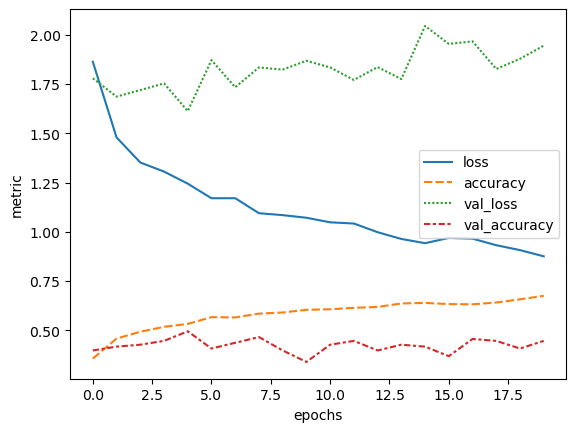

In [18]:
plot_history(history, ['loss', 'accuracy', 'val_loss', 'val_accuracy'] )

<Axes: >

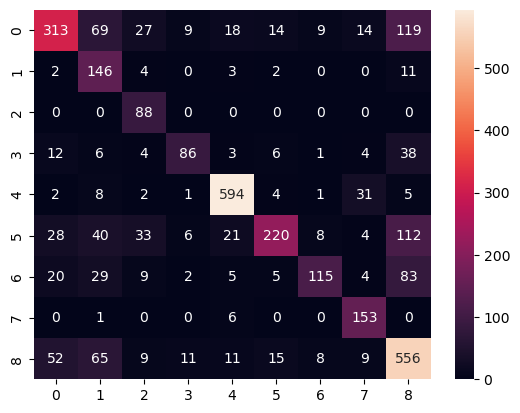

In [19]:
from sklearn.metrics import confusion_matrix

# Training data confusion matrix
true_train_label = np.argmax(y_train, axis=1)
matrix = confusion_matrix(true_train_label, ypred_train)
sns.heatmap(matrix, annot=True, fmt='.3g')

<Axes: >

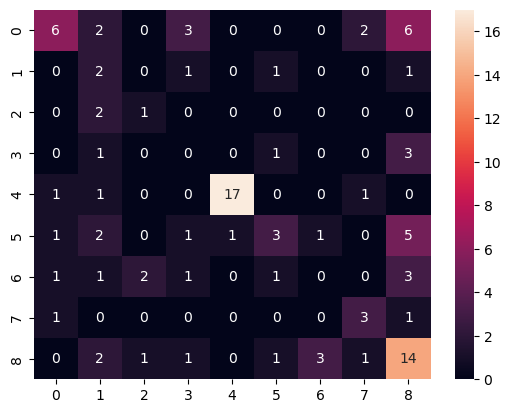

In [20]:
from sklearn.metrics import confusion_matrix

# Validation data confusion matrix
true_val_label = np.argmax(y_val, axis=1)
matrix = confusion_matrix(true_val_label, ypred_val)
sns.heatmap(matrix, annot=True, fmt='.3g')

In [21]:
import random 
print ('Correct predictions, Total samples, Accuracy')
print (np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0), y_train.shape[0], np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0)/y_train.shape[0])
print (np.count_nonzero(ypred_val - np.argmax(y_val, axis=1) == 0), y_val.shape[0], np.count_nonzero(ypred_val - np.argmax(y_val, axis=1) == 0)/y_val.shape[0])

Correct predictions, Total samples, Accuracy
2271 3296 0.6890169902912622
46 103 0.44660194174757284


In [22]:
sklearn.metrics.f1_score(np.argmax(y_val, axis=1), ypred_val, average='macro')

0.34468674880048145

In [25]:
# sklearn.metrics.log_loss(np.argmax(y_val, axis=1), ypred_val, eps=1e-15, normalize=True)